In [856]:
%load_ext autoreload
%autoreload 2
import os

# ensure is in parent directory
try:
    print(os.getcwd())
    os.chdir("../../rug-hr/")
    print(os.getcwd())
except:
    pass

import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
from tqdm import tqdm
from collections import defaultdict

import numpy as np
from scipy.ndimage import label, center_of_mass
from scipy.spatial.distance import cdist
from utils.transforms import remove_ornaments, set_adaptive_threshold

import numpy as np
import math
import random


from typing import List, Tuple, Optional

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
c:\Users\mo\Documents\Organisations\RUG\rug-hr


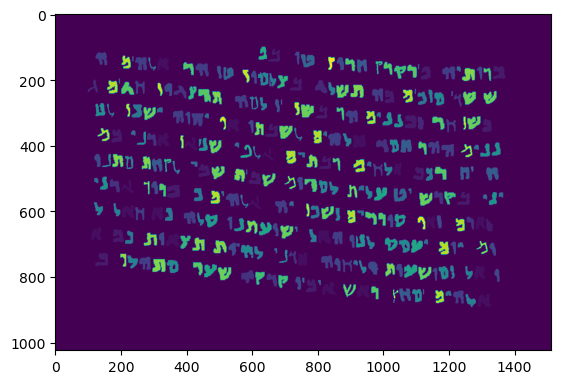

In [857]:
# show random image
masks_folder = "datasets/dss_corrupted/Raw/"
masks = os.listdir(masks_folder)
random_mask = np.random.choice(masks)
image = np.array(Image.open(masks_folder + random_mask))
plt.imshow(image)

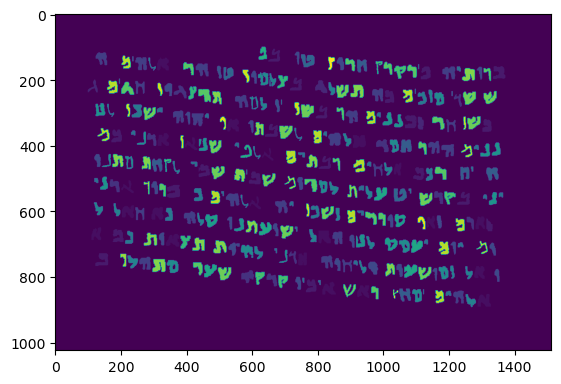

In [858]:
binary_image = np.where(image > 0, 1, 0)
allowed_pixels = remove_ornaments(binary_image, set_adaptive_threshold(binary_image))
image_without_ornaments = np.where(allowed_pixels > 0, image, 0)
plt.imshow(image_without_ornaments)

In [859]:
class Point:
    def __init__(self, x, y, label):
        self.x = x
        self.y = y
        self.label = label

    def __repr__(self):
        return f'Point({self.x}, {self.y}, "{self.label}")'


In [860]:
def find_centers_of_characters(img: np.ndarray, distance_threshold=0):
    unique_values = np.unique(img)
    unique_values = unique_values[unique_values != 0]  # Exclude background value (0)

    points = []

    for value in unique_values:
        binary_img = np.where(img == value, value, 0).astype(img.dtype)

        # Label connected components
        labeled_img, num_components = label(binary_img)

        # Calculate centers
        value_centers = center_of_mass(binary_img, labeled_img, range(1, num_components + 1))

        # Convert coordinates to integers
        int_centers = [tuple(map(int, center)) for center in value_centers]

        # Merge centers that are close together
        merged_centers = []
        for idx, center in enumerate(int_centers):
            if center in merged_centers:
                continue

            # Find the centers that are within the distance threshold
            distances = cdist([center], int_centers)[0]
            close_centers_idx = np.where(distances <= distance_threshold)[0]

            # Calculate the new combined center
            new_center = np.mean([int_centers[i] for i in close_centers_idx], axis=0)
            merged_centers.append(Point(int(new_center[0]), int(new_center[1]), value))

        points.extend(merged_centers)

    return points


points = find_centers_of_characters(image_without_ornaments)
print(points)



[Point(152, 328, "1"), Point(337, 542, "1"), Point(383, 329, "1"), Point(387, 927, "1"), Point(396, 416, "1"), Point(429, 649, "1"), Point(472, 1044, "1"), Point(527, 222, "1"), Point(577, 611, "1"), Point(601, 222, "1"), Point(607, 312, "1"), Point(633, 1145, "1"), Point(635, 1296, "1"), Point(669, 126, "1"), Point(678, 820, "1"), Point(689, 360, "1"), Point(747, 754, "1"), Point(786, 1293, "1"), Point(837, 834, "1"), Point(844, 940, "1"), Point(873, 1308, "1"), Point(128, 671, "2"), Point(178, 1354, "2"), Point(179, 1131, "2"), Point(215, 737, "2"), Point(251, 1019, "2"), Point(301, 815, "2"), Point(327, 1085, "2"), Point(340, 1317, "2"), Point(356, 663, "2"), Point(372, 188, "2"), Point(455, 826, "2"), Point(477, 454, "2"), Point(486, 1110, "2"), Point(500, 610, "2"), Point(540, 362, "2"), Point(563, 1248, "2"), Point(645, 1323, "2"), Point(675, 192, "2"), Point(748, 145, "2"), Point(829, 781, "2"), Point(221, 118, "3"), Point(222, 811, "3"), Point(332, 1113, "3"), Point(236, 383, "

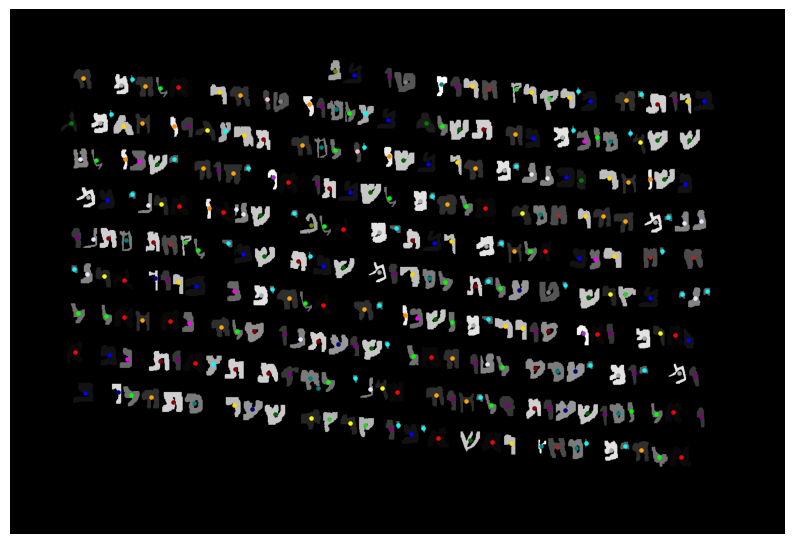

In [861]:
import matplotlib.pyplot as plt

label_to_color = {
    "1": "red",
    "2": "blue",
    "3": "green",
    "4": "yellow",
    "5": "orange",
    "6": "purple",
    "7": "pink",
    "8": "brown",
    "9": "gray",
    "10": "cyan",
    "11": "magenta",
    "12": "lime",
    "13": "teal",
    "14": "lavender",
    "15": "maroon",
    "16": "navy",
    "17": "olive",
    "18": "aqua",
    "19": "limegreen",
    "20": "gold",
    "21": "darkgreen",
    "22": "darkred",
    "23": "darkblue",
    "24": "darkgray",
    "25": "darkorange",
    "26": "darkorchid",
    "27": "darkcyan",
}


def plot_points_on_image(img: np.ndarray, points, label_to_color):
    plt.figure(figsize=(10, 10))  # Set the figure size, you can adjust this as needed
    plt.imshow(img, cmap='gray')  # Display the image in grayscale

    for point in points:
        plt.scatter(point.y, point.x, s=5, color=label_to_color[str(point.label)])

    plt.axis('off')  # remove the axis
    plt.show()  # show the plot


plot_points_on_image(image_without_ornaments, points, label_to_color)


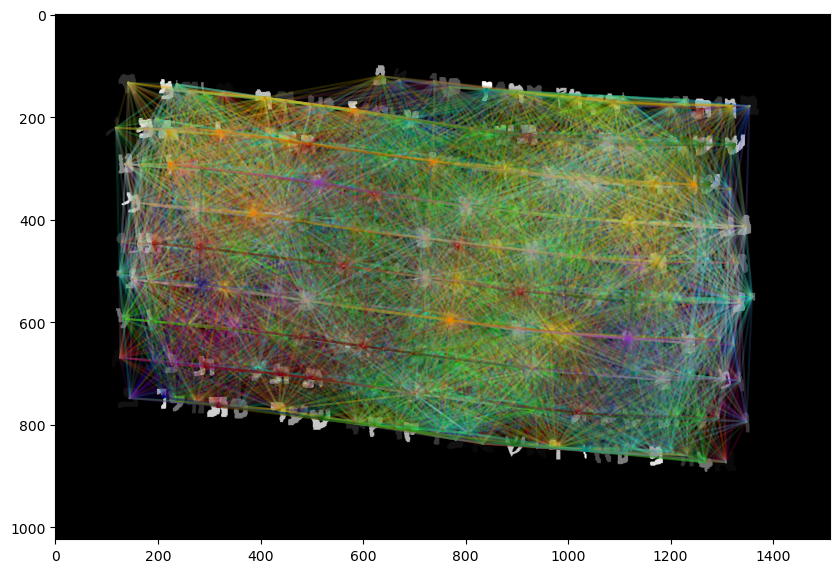

In [862]:
def construct_graph(points, max_distance=300):
    graph = {}
    for u in points:
        graph[u] = []
        for v in points:
            if u == v:
                continue

            distance = math.sqrt((u.x - v.x) ** 2 + (u.y - v.y) ** 2)
            if distance <= max_distance:
                graph[u].append(v)

    return graph

graph = construct_graph(points)

def plot_graph(img: np.ndarray, graph, label_to_color):
    plt.figure(figsize=(10, 10))  # Set the figure size, you can adjust this as needed
    plt.imshow(img, cmap='gray')  # Display the image in grayscale

    for u, neighbors in graph.items():
        for v in neighbors:
            plt.plot([u.y, v.y], [u.x, v.x], color=label_to_color[str(u.label)], alpha=0.1)

    # plt.axis('off')  # remove the axis
    plt.show()  # show the plot

plot_graph(image_without_ornaments, graph, label_to_color)

In [1399]:
def transpose_points(points):
    return [Point(point.y, point.x, point.label) for point in points]

def plot_lines(img: np.ndarray, lines, label_to_color):
    plt.figure(figsize=(10, 10))  # Set the figure size, you can adjust this as needed
    plt.imshow(img, cmap='gray')  # Display the image in grayscale

    for line in lines:
        for i in range(len(line) - 1):
            u = line[i]
            v = line[i + 1]
            plt.plot([u.y, v.y], [u.x, v.x], color=label_to_color[str(u.label)], alpha=1)

    # plt.axis('off')  # remove the axis
    plt.show()  # show the plot

def line_fitness(
        line, 
        line_w=0.1,
        angle_w=0.9,):
    
    # Compute angle reward
    angles = []
    dists = []
    for i in range(len(line) - 2):
        p0 = line[i]
        p1 = line[i + 1]
        p2 = line[i + 2]

        v1 = np.array([p1.x - p0.x, p1.y - p0.y])
        v2 = np.array([p1.x - p2.x, p1.y - p2.y])

        # Ensure line doesnt deviate from x axis too much
        y = np.abs(v1[1])
        angle = np.arcsin(y / np.linalg.norm(v1))
        if angle >= np.pi*0.1:
            return -np.inf

        # Ensure line does not have sharp turns
        angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
        if angle <= np.pi*0.75:
            return -np.inf

        angles.append(angle)
        dists.append(np.linalg.norm(v1))
    
    curvature = np.max(angles) if len(angles) >= 3 else 0
    tightness = -np.mean(dists) if len(dists) >= 3 else 0

    fitness = curvature*angle_w + len(line)*line_w + tightness
    return curvature + tightness


def find_best_line(graph, line, fitness_threshold=-50):
    """
    Recursively find the best line 
    Args:
        graph: the graph
        line: the current line so far starting with [p0, p1, ..., pn] sorted by x coordinate
    Returns:
        the best line starting with [starting_point], fitness of the line
    """
    
    best_line = line
    best_line_fitness = line_fitness(line)

    if len(line) >= 32:
        return None, best_line_fitness

    # Evaluate whether to keep line and extend it
    if fitness_threshold >= best_line_fitness:
        return None, best_line_fitness

    # Mark the ends of the line
    starting_points = [line[-1]]
    if len(line) != 1:
        starting_points.append(line[-2])

    for starting_point in starting_points:
        neighbors = graph[starting_point]
        for neighbor in neighbors:
            if neighbor in line:
                continue
            
            # Explore all new actions to extend the line
            new_line = line + [neighbor]
            new_line = sorted(new_line, key=lambda p: p.x)
            if line_fitness(new_line) < best_line_fitness:
                continue
            new_line, new_line_fitness = find_best_line(graph, new_line, fitness_threshold)

            if new_line_fitness > best_line_fitness:
                best_line = new_line
                best_line_fitness = new_line_fitness
    
    return best_line, best_line_fitness

def extract_lines(graph):
    lines = []

    _graph = graph.copy()        
    while len(_graph) > 0:
        # take point with max y
        # starting_point = max(_graph.keys(), key=lambda p: p.y)
        starting_point = random.choice(list(_graph.keys()))
        line, fitness = find_best_line(_graph, [starting_point])
        lines.append(line)
        break
        # remove points from graph
        for point in line:
            # remove references to this point
            for neighbors in _graph.values():
                if point in neighbors:
                    neighbors.remove(point)
            del _graph[point]

    return lines

ps = transpose_points(points)
graph = construct_graph(ps)
lines = extract_lines(graph)
lines = [transpose_points(line) for line in lines]

plot_lines(image_without_ornaments, lines, label_to_color)

KeyboardInterrupt: 